# Stan spline implementation

Test out the Stan code by trying to reproduce the same results as python.

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import stan_utility

## 1D spline basis 

In [22]:
# Define spline
p = 3 
knots = np.array([0.0, 0.5, 1.5, 3.5, 4.0])
Nevals = 1000
xvals = np.linspace(knots[0], knots[-1], Nevals)

In [27]:
# Compile stan model
spline_eval = stan_utility.compile_model(filename = '1D_spline_basis.stan', 
                                         model_name = 'spline_eval')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL spline_eval_16b5b98cfe2439ac027a3ee0fde70c07 NOW.


In [28]:
# Evaluate and extract output
spline_input = {'p' : p, 'Lknots' : len(knots), 'knots' : knots, 
                 'Nevals' : Nevals, 'xvals' : xvals}
output = spline_eval.sampling(data = spline_input, 
                              iter=1, chains=1, algorithm="Fixed_param")
yvals = output.extract(['yvals'])['yvals'][0]

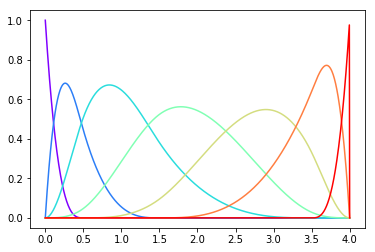

In [29]:
# Plot
Nknots = len(knots)+p-1 
color=iter(cm.rainbow(np.linspace(0,1,Nknots))) # loop through colors
for idx in range(Nknots):
    c = next(color)
    plt.plot(xvals, yvals[idx], color=c, linestyle='solid')
    
# Yay! it works.

## Comparison with Scipy
Represent arbitrary function as superposition of b-splines and compare with scipy to verify.

In [33]:
# Compile stan model
bspline_func_1D = stan_utility.compile_model(filename = 'bspline_func_1D.stan', 
                                         model_name = 'bspline_func_1D')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL bspline_func_1D_5d6fa0c1ea360794d77d02c081ac50c0 NOW.


In [34]:
# generate fake data from arbitrary curve 
np.random.seed(1)
xmin = -2.
xmax = 2.
xobs = np.linspace(xmin, xmax, 15)
stderr = 1.0
yobs = xobs**3+np.random.normal(0.0, stderr, len(xobs))

# now interpolate with scipy
from scipy.interpolate import UnivariateSpline

# scipy denotes degree of spline with k (meh!)
# should be p=k-1 if De Boor's notation is used.
func = UnivariateSpline(xobs, yobs, s=30, k=p)

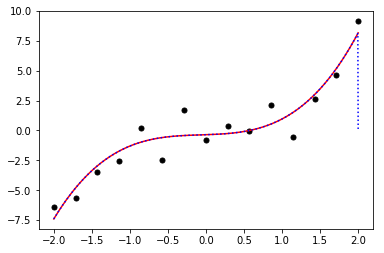

In [35]:
Nevals = 1000
new_x = np.linspace(xmin, xmax, Nevals)
new_y = func(new_x)
plt.figure()
plt.plot(xobs, yobs, ".", markersize=10, color='black')
plt.plot(new_x, new_y, "r-")

# now run Stan code
knots = np.unique(func.get_knots()) # strip possible padded knots (scipy is inconsistent here)
coeffs = func.get_coeffs()

spline_input = {'p' : p, 'Lknots' : len(knots), 'knots' : knots, 'c' : coeffs,
                'Nevals' : Nevals, 'xvals' : new_x}
output = bspline_func_1D.sampling(data = spline_input, 
                                  iter=1, chains=1, algorithm="Fixed_param")
new_y = output.extract(['yvals'])['yvals'][0]

plt.plot(new_x, new_y, color='blue', linestyle='dotted')

# notice the prefect match :) and be happy!

In [ ]:
# Lets generalize to 2D by means of tensor-product splines
# and first plot two elements of the tensor-product spline basis

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bspline_ev import bspline_func_2d

p = 3 # spline degree
knots_x = np.array([0.0, 0.5, 1.5, 3.5, 4.0]) # arbitrary knot sequence
knots_y = np.array([0.0, 1.0, 2.5, 4.0]) # another arbitrary knot sequence

Nx = len(knots_x)+p-1 # number of coefficients that need to be defined along x
Ny = len(knots_y)+p-1 # number of coefficients that need to be defined along y
N = Nx * Ny # total number of entries for coefficient matrix

# in order to fish a single basis element we create a matrix with only one non-zero entry
c = np.zeros(N) 
c[25]=1 # all coefficients zero except for one
c = c.reshape(Nx, Ny)
func = bspline_func_2d(knots_x, knots_y, p, c)

xaxis = np.linspace(knots_x[0], knots_y[-1], 100)
yaxis = np.linspace(knots_x[0], knots_y[-1], 100)

z1 = np.asarray([func.eval(tx, ty) for tx in xaxis for ty in yaxis])
z1 = z1.reshape(len(xaxis), len(yaxis))

# we can do the same for another basis element
c = np.zeros(N) 
c[35]=1 # all coefficients zero except for one
c = c.reshape(Nx, Ny)
func = bspline_func_2d(knots_x, knots_y, p, c)

z2 = np.asarray([func.eval(tx, ty) for tx in xaxis for ty in yaxis])
z2 = z2.reshape(len(xaxis), len(yaxis))

xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z1, rstride=5, cstride=5, color='blue') # plot element 1
surf = ax.plot_wireframe(xx, yy, z2, rstride=5, cstride=5, color='red') # plot element 2
ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
# and now the example from the effective area for nue CC interactions
# coefficients and knots are taken from a smoothing spline fit created using 
# scipy's RectBivariateSpline implementation

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bspline_ev import bspline_func_2d

p = 3 # spline degree
tx_orig = np.array([2.90998783, 4.03010253, 5.00991847, 6.96995941]) # knot sequence
ty_orig = np.array([-0.9,  0.1,  0.9]) # knot sequence
Nx = len(tx_orig)+p-1 # number of coefficients that need to be defined
Ny = len(ty_orig)+p-1 # number of coefficients that need to be defined
N = Nx * Ny


c = np.asarray([-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
 -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
 -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
  0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
  1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])

c = c.reshape(Nx, Ny)
func = bspline_func_2d(tx_orig, ty_orig, p, c)

xaxis = np.linspace(tx_orig[0], tx_orig[-1], 100)
yaxis = np.linspace(ty_orig[0], ty_orig[-1], 100)

import time
t0 = time.time()
z = np.asarray([func.eval(tx, ty) for tx in xaxis for ty in yaxis])
t1 = time.time()
print('Finished after {} minutes'.format((t1 - t0) / 60))

z = z.reshape(len(xaxis), len(yaxis))
xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')